# Research and Innovation Project 

Aimée Simcic-Mori & Sophia Yazzourh 

Tutor : Nicolas Savy 

Subjet : U-shape curve in logistic regression with a quantitativeexplanatory variable

## 0. Loading Libraries

In [411]:
# Data science
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# RMS 
from sklearn.metrics import mean_squared_error
from math import sqrt
# Splines
from patsy import dmatrix , build_design_matrices
# Statical Model
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Model Selection
from sklearn.feature_selection import SelectFromModel
# Accuracy
from sklearn.metrics import accuracy_score

In [412]:
### Suppression of unnecessary warnings due to the forced transformation of certain variables
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## I. Data

### I.1 Importation & Preperation

In [413]:
### Data importation
data = pd.read_excel("./Base_PBM_Facteurs_Confusion.xlsx")

Notre variables response Y correspond à la column "transfusion CG". On ne s'intéresse pas au type de transfusion mais seulement si elle a eu lieu ou non. On transformera alors cette variable en variable binaire tel que 0 corresspond à "pas de transfusion" tandis que 1 corresspond à "transfusion". 

In [414]:
### Data cleaning
# Binary transformation of the Y response variable
data["transfusion CG"][np.where(data["transfusion CG"] > 0)[0]] = 1
# Supression of missing data
data.dropna(inplace=True)
# Re indexation
data.set_index(np.arange(len(data)))
# Display data informations
print("Longueur des données : " + str(len(data)))
print("Nombre de columns : " + str(len(data.columns)))
data.head()

Longueur des données : 435
Nombre de columns : 22


,age,poids,taille,imc,redux,hta,diabete,avk,aod,plavix,...,betabloquant,diuretiques,hb,ferritinemie,coeff de sat,type intervention,duree rea,fibrinogene,Fibrinogène rdb,transfusion CG
0,69.0,68.0,1.63,25.593,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,14.6,56.0,14.0,1,1.0,3.64,2.27,0.0
1,65.0,71.0,1.72,23.999,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,14.0,199.0,20.0,2,2.0,1.91,1.30,0.0
2,79.0,79.0,1.60,30.859,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,12.9,51.0,26.0,5,2.0,3.57,2.43,1.0
3,80.0,69.0,1.69,24.158,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,14.6,387.0,21.0,1,1.0,2.43,1.78,0.0
4,72.0,80.0,1.70,27.681,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,11.6,24.0,6.0,5,2.0,4.15,3.23,1.0


Pour chaque individu nous avons une variables réponse "transfusion CG" et 21 variables explicatives. 

On notera qu'on ne travaillera qu'avec soit "fibrinogène" ou soit "fibrinigène rdb". Afin que notre travail corresponde et se place dans le même contexte que l'article "Preoperative plasma fibrinogen level and transfusion in cardiac surgery: a biphasic correlation" de Hélène Charbonneaua, Marie Pasquieb et Nicolas Mayeur, on utilisera la variable "fibrinogène rdb". 

Les variables réponses se répartissent selon les caractéristiques suivantes : 

- binaires : redux, hta, diabete, avk, aod, plavix, kardegic, autres aap, betabloquant, diuretiques, 
- continues : imc, hb, ferritinemie, coeff de sat, duree rea, Fibrinogène rdb, fibrinogene
- catégorielles : type intervention

In [415]:
data.describe()

,age,poids,taille,imc,redux,hta,diabete,avk,aod,plavix,...,autres aap,betabloquant,diuretiques,hb,ferritinemie,coeff de sat,duree rea,fibrinogene,Fibrinogène rdb,transfusion CG
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,...,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.00000
mean,68.011494,77.536782,2.030575,27.086400,0.062069,0.652874,0.213793,0.085057,0.103448,0.085057,...,0.013793,0.508046,0.344828,13.956322,189.662069,21.439080,3.328736,3.172828,2.133080,0.36092
std,10.250204,15.539967,7.111554,4.557788,0.241559,0.476605,0.410455,0.279288,0.304894,0.279288,...,0.116766,0.500511,0.475859,1.413016,163.805207,7.412646,2.883287,0.760864,0.614638,0.48082
min,22.000000,45.000000,1.470000,19.077000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.100000,7.000000,3.000000,1.000000,1.700000,0.850000,0.00000
25%,64.000000,67.000000,1.625000,23.735500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,13.000000,73.000000,16.000000,2.000000,2.655000,1.740000,0.00000
50%,70.000000,77.000000,1.700000,26.346000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,13.900000,140.000000,21.000000,2.000000,3.070000,2.030000,0.00000
75%,75.000000,86.000000,1.750000,29.408500,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,14.900000,258.000000,26.000000,4.000000,3.620000,2.430000,1.00000
max,84.000000,153.000000,150.000000,49.950000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,18.700000,962.000000,48.000000,35.000000,7.080000,4.700000,1.00000


On remarquera que certaines valeurs on put être mal notées dans la base données. Par exemple la taille maximale est de 150.000 or elle aurait surment dût être de 1.50. 

### I.2 Première étude de la varible d'intérêt "Fibrinogène rdb"

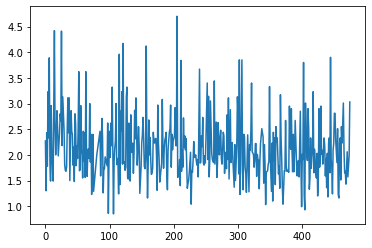

In [416]:
plt.plot(data["Fibrinogène rdb"])

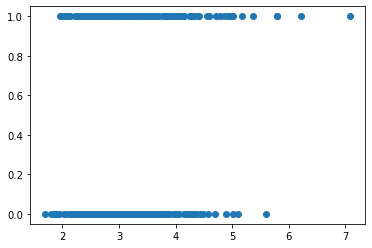

In [417]:
plt.scatter(data["fibrinogene"], data["transfusion CG"])

## II. Transformation de la variable explicative fibrinogène

Dans cette partie, nous allons transformée par splines d'interpolation la variable d'intérêt "Fibrinogène rdb" afin d'éviter un passage par catégorisation et obtenir un modèle plus généraliste. 

### II.1 Les types de splines 

#### II.1.1 Les B-Splines 

Petit texte sur les B splines 

Optimization terminated successfully.
         Current function value: 0.617392
         Iterations 7
0.4624059196323001


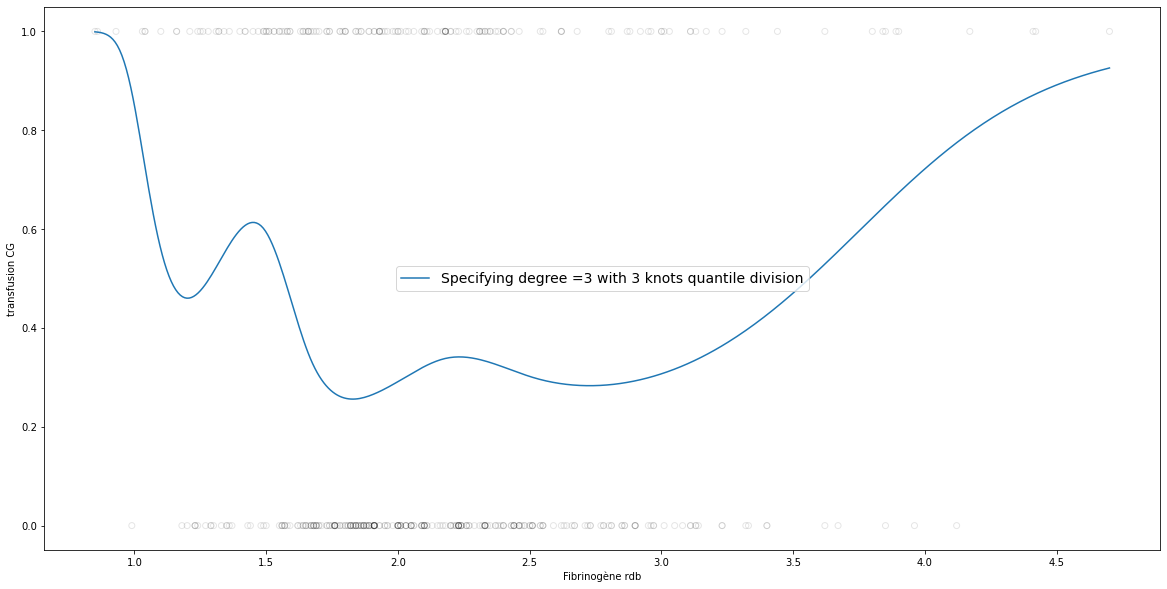

In [469]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

# Generating cubic spline with 3 knots
transformed_x = dmatrix("bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit()

# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.49, 1.67, 1.91, 2.18, 2.516), include_intercept=False)", {"valid": x}, return_type='dataframe'))

# Calculating RMSE values
rms1 = sqrt(mean_squared_error(y, pred1))
print(rms1)

# We will plot the graph 
xp = np.linspace(x.min(),x.max(),453)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(1.49, 1.67, 1.91, 2.18, 2.516), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.figure(figsize=(20,10))
plt.scatter(x, y, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots quantile division')
#plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots function division')
plt.legend(prop={'size': 14})
plt.xlabel('Fibrinogène rdb')
plt.ylabel('transfusion CG')
plt.show()

#### II.1.2 Les Natural Cubic Splines 

Petit texte sur les Natural Cubic Spline et leur différence avec les B Splines 

Optimization terminated successfully.
         Current function value: 0.622945
         Iterations 8
0.4651466343047561


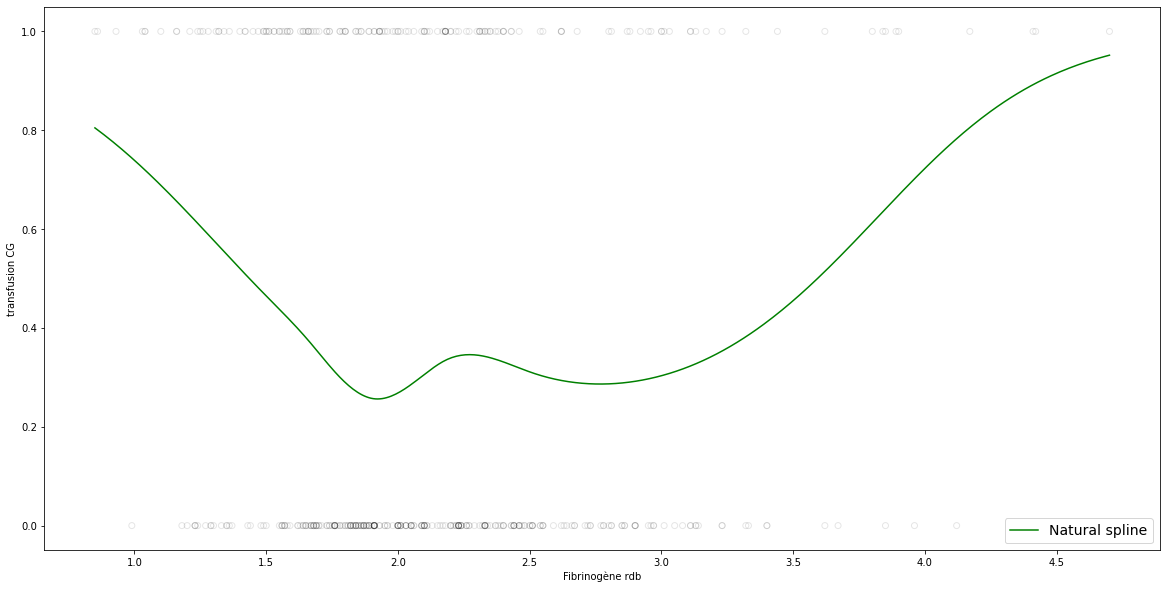

In [466]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))", {"train": x}, return_type='dataframe')
fit3 = sm.Logit(y, transformed_x3 ).fit()

# Prediction 
pred3 = fit3.predict(dmatrix("cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))", {"train": x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(y, pred3))
print(rms)

# We will plot the graph for 300 observations 
xp = np.linspace(x.min(),x.max(),453)
pred3 = fit3.predict(dmatrix("cr(xp, knots=(1.49, 1.67, 1.91, 2.18, 2.516))", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.figure(figsize=(20,10))
plt.scatter(x, y, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3, color='g', label='Natural spline')
plt.legend(prop={'size': 14})
plt.xlabel('Fibrinogène rdb')
plt.ylabel('transfusion CG')
plt.show()

On choisira les B Splines car elle collent au modèles que l'on veut reproduire, se trouvant dans l'article 

### II.2 Number and positions of knots evaluated by accuracy 

In [420]:
### Création du tableau de résultats 
Res_Acc = pd.DataFrame(0, index = ['3 knots','4 knots','5 knots', 'Quantile 1, 3 knots', 'Quantile 2, 3 knots', 'Quantile 5 knots', 'Cut 3 knots', 'Cut 4 knots', 'Cut 5 knots', 'Fractile 3 knots', 'Fractile 5 knots'], columns = ['Accuracy BSpline'])


##### II.2.1. B Splines

In [464]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

# Generating cubic spline 
transformed_x = dmatrix("bs(train, df = 3, degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, df = 3, include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['3 knots'] = accuracy_score(y, prediction)


# Generating cubic spline 
transformed_x = dmatrix("bs(train, df = 4, degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, df = 4, include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['4 knots'] = accuracy_score(y, prediction)

# Generating cubic spline 
transformed_x = dmatrix("bs(train, df = 5, degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, df = 5, include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['5 knots'] = accuracy_score(y, prediction)

In [422]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

####### Quantiles 
k2 = data.quantile(0.25)["Fibrinogène rdb"] 
k3 = data.quantile(0.50)["Fibrinogène rdb"] 
k4 = data.quantile(0.75)["Fibrinogène rdb"] 
#print("Noeud 1 : " +  str(k2))
#print("Noeud 2 : " +  str(k3))
#print("Noeud 3 : " +  str(k4))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.74, 2.03, 2.43), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.74, 2.03, 2.43), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Quantile 1, 3 knots'] = accuracy_score(y, prediction)

x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

####### Quantiles 2 

# Divide by quantiles 
k2 = data.quantile(0.05)["Fibrinogène rdb"] 
k3 = data.quantile(0.50)["Fibrinogène rdb"] 
k4 = data.quantile(0.95)["Fibrinogène rdb"] 
#print("Noeud 1 : " +  str(k2))
#print("Noeud 2 : " +  str(k3))
#print("Noeud 3 : " +  str(k4))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.287, 2.03, 3.23), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.287, 2.03, 3.23), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Quantile 2, 3 knots'] = accuracy_score(y, prediction)

x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

####### Quantiles 3

# Divide by quantiles 
k1 = data.quantile(0.05)["Fibrinogène rdb"] 
k2 = data.quantile(0.25)["Fibrinogène rdb"] 
k3 = data.quantile(0.50)["Fibrinogène rdb"] 
k4 = data.quantile(0.75)["Fibrinogène rdb"] 
k5 = data.quantile(0.95)["Fibrinogène rdb"] 
#print("Noeud 1 : " +  str(k1))
#print("Noeud 2 : " +  str(k2))
#print("Noeud 3 : " +  str(k3))
#print("Noeud 4 : " +  str(k4))
#print("Noeud 3 : " +  str(k5))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.287, 1.74, 2.03, 2.43, 3.23), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.287, 1.74, 2.03, 2.43, 3.23), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Quantile 5 knots'] = accuracy_score(y, prediction)


In [467]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

####### Divide with pd.cut function


# Divide by function
# Dividing the data into 4 bins to have 3 knots
df_cut, bins = pd.cut(x, 4, retbins=True, right=True)
#print(df_cut.value_counts(sort=False))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.812, 2.775, 3.7385), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.812, 2.775, 3.7385), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Cut 3 knots'] = accuracy_score(y, prediction)

# Divide by function
# Dividing the data into 5 bins to have 4 knots
df_cut, bins = pd.cut(x, 5, retbins=True, right=True)
#print(df_cut.value_counts(sort=False))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.62, 2.39, 3.16, 3.93), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.62, 2.39, 3.16, 3.93), degree=3, include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Cut 4 knots'] = accuracy_score(y, prediction)

# Divide by function
# Dividing the data into 6 bins to have 5 knots
df_cut, bins = pd.cut(x, 6, retbins=True, right=True)
#print(df_cut.value_counts(sort=False))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.492, 2.133, 2.775, 3.417, 4.058), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.492, 2.133, 2.775, 3.417, 4.058), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Cut 5 knots'] = accuracy_score(y, prediction)

In [425]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

####### Percentil 3 knots
k2 = np.percentile(data['Fibrinogène rdb'],20)
k3 = np.percentile(data['Fibrinogène rdb'],40)
k4 = np.percentile(data['Fibrinogène rdb'],60)
#print("Noeud 1 : " +  str(k2))
#print("Noeud 2 : " +  str(k3))
#print("Noeud 3 : " +  str(k4))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.67, 1.91, 2.18), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.67, 1.91, 2.183), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Fractile 3 knots'] = accuracy_score(y, prediction)


####### Percentil 5 knots

k1 = np.percentile(data['Fibrinogène rdb'],10)
k2 = np.percentile(data['Fibrinogène rdb'],20)
k3 = np.percentile(data['Fibrinogène rdb'],40)
k4 = np.percentile(data['Fibrinogène rdb'],60)
k5 = np.percentile(data['Fibrinogène rdb'],80)
#print("Noeud 1 : " +  str(k1))
#print("Noeud 2 : " +  str(k2))
#print("Noeud 3 : " +  str(k3))
#print("Noeud 4 : " +  str(k4))
#print("Noeud 3 : " +  str(k5))

# Generating cubic spline 
transformed_x = dmatrix("bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.49, 1.67, 1.91, 2.18, 2.516), include_intercept=False)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
Res_Acc.loc['Fractile 5 knots'] = accuracy_score(y, prediction)

In [426]:
Res_Acc

,Accuracy BSpline
3 knots,0.657471
4 knots,0.659770
5 knots,0.659770
"Quantile 1, 3 knots",0.657471
"Quantile 2, 3 knots",0.666667
Quantile 5 knots,0.671264
Cut 3 knots,0.659770
Cut 4 knots,0.657471
Cut 5 knots,0.671264
Fractile 3 knots,0.659770


##### II.2.1. Natural Cubic Splines

In [427]:
x = data["Fibrinogène rdb"] 
y = data["transfusion CG"]

# Generating cubic spline 
transformed_x = dmatrix("cr(train, knots=(1.287, 1.74, 2.03, 2.43, 3.23))", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("cr(valid, knots=(1.287, 1.74, 2.03, 2.43, 3.23))", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
print("Accuracy 3 knots : " + str(accuracy_score(y, prediction)))

# Generating cubic spline 
transformed_x = dmatrix("cr(train, df = 4)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("cr(valid, df = 4)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
print("Accuracy 4 knots : " + str(accuracy_score(y, prediction)))

# Generating cubic spline 
transformed_x = dmatrix("cr(train, df = 5)", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("cr(valid, df = 5)", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
print("Accuracy 5 knots : " + str(accuracy_score(y, prediction)))
####### Percentil 3 knots
k2 = np.percentile(data['Fibrinogène rdb'],20)
k3 = np.percentile(data['Fibrinogène rdb'],40)
k4 = np.percentile(data['Fibrinogène rdb'],60)
#print("Noeud 1 : " +  str(k2))
#print("Noeud 2 : " +  str(k3))
#print("Noeud 3 : " +  str(k4))

# Generating cubic spline 
transformed_x = dmatrix("cr(train, knots=(1.67, 1.91, 2.18))", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("cr(valid, knots=(1.67, 1.91, 2.183))", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
print("Accuracy fractile 3 knots : " + str(accuracy_score(y, prediction)))


####### Percentil 5 knots

# Divide by quantiles 
k1 = np.percentile(data['Fibrinogène rdb'],10)
k2 = np.percentile(data['Fibrinogène rdb'],20)
k3 = np.percentile(data['Fibrinogène rdb'],40)
k4 = np.percentile(data['Fibrinogène rdb'],60)
k5 = np.percentile(data['Fibrinogène rdb'],80)
#print("Noeud 1 : " +  str(k1))
#print("Noeud 2 : " +  str(k2))
#print("Noeud 3 : " +  str(k3))
#print("Noeud 4 : " +  str(k4))
#print("Noeud 3 : " +  str(k5))

# Generating cubic spline 
transformed_x = dmatrix("cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))", {"train": x},return_type='dataframe')
# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit(disp = False)
# Predictions
pred1 = fit1.predict(dmatrix("cr(valid, knots=(1.49, 1.67, 1.91, 2.18, 2.516))", {"valid": x}, return_type='dataframe'))
prediction = list(map(round, pred1)) 
print("Accuracy fractile 5 knots : " + str(accuracy_score(y, prediction)))

Accuracy 3 knots : 0.6597701149425287
Accuracy 4 knots : 0.6597701149425287
Accuracy 5 knots : 0.6574712643678161
Accuracy fractile 3 knots : 0.6597701149425287
Accuracy fractile 5 knots : 0.6620689655172414


## III. Modéles de Regression Logistique avant la sélection de variables

### III.1 Modèle complet de Régression Logisique Logistique avec une catégorisation

Here, we will categorize our X variable "Fibrinogène rdb" with the same classes as the article "Preoperative plasma fibrinogen level and transfusion in cardiac surgery: a biphasic correlation" from Hélène Charbonneaua, Marie Pasquieb and Nicolas Mayeur. 

In [429]:
Facteurs_Confusion = data.copy()
# Categorization
Facteurs_Confusion['Fibri Cat 1'] = (data["Fibrinogène rdb"] < 1.5)*1
Facteurs_Confusion['Fibri Cat 2'] = (data["Fibrinogène rdb"] >= 1.5)*(data["Fibrinogène rdb"] < 2)*1
Facteurs_Confusion['Fibri Cat 3'] = (data["Fibrinogène rdb"] >= 2)*(data["Fibrinogène rdb"] < 2.5)*1
Facteurs_Confusion['Fibri Cat 4'] = (data["Fibrinogène rdb"] >= 2.5)*(data["Fibrinogène rdb"] < 3)*1
Facteurs_Confusion['Fibri Cat 5'] = (data["Fibrinogène rdb"] > 3)*1
# Confounding Factors cleaning
del Facteurs_Confusion['fibrinogene']
del Facteurs_Confusion['transfusion CG']
del Facteurs_Confusion['Fibrinogène rdb']
X_C = Facteurs_Confusion
y = data["transfusion CG"]
## Model 
from sklearn.linear_model import LogisticRegression
logitC = LogisticRegression().fit(X_C,y)

In [471]:
X_C.to_csv("Facteurs_Confusion_Categorization.csv")

### III.2 Modèle complet de Régression Logisique Logistique avec la transformation en B Spline 

In [430]:
## Spline
## Cubic spline (B_Spline) process on fibrinogene rdb
transformed_fibriB = dmatrix("bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)", {"train": data['Fibrinogène rdb']},return_type='dataframe')
Facteurs_Confusion_Spline = pd.concat([data.copy(),transformed_fibriB], axis = 1)

## Supp no-needed columns
del Facteurs_Confusion_Spline['fibrinogene']
del Facteurs_Confusion_Spline['transfusion CG']
del Facteurs_Confusion_Spline['Fibrinogène rdb']
del Facteurs_Confusion_Spline['Intercept']
X = Facteurs_Confusion_Spline
y = data["transfusion CG"]
## Model 
from sklearn.linear_model import LogisticRegression
logitS = LogisticRegression().fit(X,y)

In [475]:
X.to_csv("Facteurs_Confusion_BSpline.csv")

### III.3 Modèle complet de Régression Logisique Logistique avec la transformation en Natural Cubic Spline 

In [431]:
## Spline
## Natural Cubic spline process on fibrinogene rdb
transformed_fibriN = dmatrix("cr(train,  knots=(1.49, 1.67, 1.91, 2.18, 2.516))", {"train": x}, return_type='dataframe')
Facteurs_Confusion_SplineN = pd.concat([data.copy(),transformed_fibriN], axis = 1)

## Supp no-needed columns
del Facteurs_Confusion_SplineN['fibrinogene']
del Facteurs_Confusion_SplineN['transfusion CG']
del Facteurs_Confusion_SplineN['Fibrinogène rdb']
del Facteurs_Confusion_SplineN['Intercept']
X_N = Facteurs_Confusion_SplineN
y = data["transfusion CG"]
## Model 
from sklearn.linear_model import LogisticRegression
logitN = LogisticRegression().fit(X_N,y)

In [473]:
X_N.to_csv("Facteurs_Confusion_Natural.csv")

In [474]:
y.to_csv("Variable_Reponse.csv")

## IV. Sélection de variables 

### IV.1 AIC & BIC sur R

Rajouter texte sur les résultats obtenus sur R 

### IV.2. Sélection par critère LASSO 

https://scikit-learn.org/stable/modules/feature_selection.html

L1-based feature selection Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with feature_selection.SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the linear_model.Lasso for regression, and of linear_model.LogisticRegression and svm.LinearSVC for classification.

#### IV.2.1 B Splines 

In [432]:
model = SelectFromModel(logitS, prefit=True)
X_new = model.transform(X)
feature_names = np.array(X.columns)
print("Variables conservées par la sélection LASSO: "
      f"{feature_names[model.get_support()]}")

Variables conservées par la sélection LASSO: ['taille' 'redux' 'hta' 'diabete' 'aod' 'kardegic' 'betabloquant' 'hb'
 'type intervention' 'duree rea'
 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[0]'
 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[1]'
 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[3]'
 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[4]']


#### IV.2.2 Natural Cubic Splines 

In [433]:
model = SelectFromModel(logitN, prefit=True)
X_new = model.transform(X_N)
feature_names = np.array(X_N.columns)
print("Variables conservées par la sélection LASSO: "
      f"{feature_names[model.get_support()]}")

Variables conservées par la sélection LASSO: ['taille' 'redux' 'diabete' 'aod' 'kardegic' 'betabloquant' 'hb'
 'type intervention' 'duree rea'
 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[1]'
 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[2]'
 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[3]']


#### IV.2.3 Categorization 

In [434]:
model = SelectFromModel(logitC, prefit=True)
X_new = model.transform(X_C)
feature_names = np.array(X_C.columns)
print("Variables conservées par la sélection LASSO: "
      f"{feature_names[model.get_support()]}")

Variables conservées par la sélection LASSO: ['taille' 'redux' 'diabete' 'aod' 'kardegic' 'betabloquant' 'hb'
 'type intervention' 'duree rea' 'Fibri Cat 1' 'Fibri Cat 3' 'Fibri Cat 4'
 'Fibri Cat 5']


### IV.3. Sélection backward basée sur la p_valeur

#### IV.3.1 B Splines 

In [435]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y.astype(float),X_1.astype(float)).fit()
print(model.pvalues)
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p=[]
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y.astype(float),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print("Variables conservées par la sélection backward basée sur la pvaleur : ")
print(str(selected_features_BE))

const                                                                                     3.540328e-06
age                                                                                       8.112835e-02
poids                                                                                     4.950679e-04
taille                                                                                    2.284538e-01
imc                                                                                       4.548729e-02
redux                                                                                     2.185229e-02
hta                                                                                       6.482508e-01
diabete                                                                                   2.103254e-01
avk                                                                                       4.191220e-01
aod                                                                      

#### IV.3.2 Natural Cubic Splines 

In [436]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_N)
#Fitting sm.OLS model
model = sm.OLS(y.astype(float),X_1.astype(float)).fit()
print(model.pvalues)
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p=[]
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y.astype(float),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print("Variables conservées par la sélection backward basée sur la pvaleur : ")
print(str(selected_features_BE))

const                                                  5.262881e-06
age                                                    8.231470e-02
poids                                                  4.072358e-04
taille                                                 2.255491e-01
imc                                                    4.154015e-02
redux                                                  2.164677e-02
hta                                                    7.004626e-01
diabete                                                2.056568e-01
avk                                                    4.083749e-01
aod                                                    6.551835e-02
plavix                                                 7.583964e-01
kardegic                                               1.431012e-01
autres aap                                             2.186325e-01
betabloquant                                           9.719973e-01
diuretiques                                     

#### IV.3.3 Categorization 

In [437]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_C)
#Fitting sm.OLS model
model = sm.OLS(y.astype(float),X_1.astype(float)).fit()
print(model.pvalues)
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p=[]
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y.astype(float),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print("Variables conservées par la sélection backward basée sur la pvaleur : ")
print(str(selected_features_BE))

const                1.979986e-05
age                  8.600487e-02
poids                1.253994e-04
taille               2.728369e-01
imc                  2.031490e-02
redux                1.402947e-02
hta                  6.772523e-01
diabete              3.135669e-01
avk                  4.152660e-01
aod                  8.916630e-02
plavix               8.468300e-01
kardegic             1.063571e-01
autres aap           2.007101e-01
betabloquant         8.793017e-01
diuretiques          6.863897e-01
hb                   5.453895e-08
ferritinemie         7.288974e-01
coeff de sat         5.850491e-01
type intervention    7.787645e-05
duree rea            2.634649e-06
Fibri Cat 1          3.332621e-01
Fibri Cat 2          8.715537e-02
Fibri Cat 3          9.851931e-02
Fibri Cat 4          5.639749e-02
Fibri Cat 5          2.003073e-01
dtype: float64
Variables conservées par la sélection backward basée sur la pvaleur : 
['poids', 'imc', 'kardegic', 'hb', 'type intervention', 'duree r

### IV.4. The final model

#### IV.4.1 B Splines
In order to select the variables of the model, we use a concatenation of the results of the 4 methods. 

Finally, we keep : 

- all coefficients of spline transformation 
- hb
- aod
- kardegic
- poids
- type intervention 
- duree rea 

In [438]:
X_Select = X[['hb','aod','kardegic','poids','type intervention', 'duree rea']]
X_Select = pd.concat([X_Select, X[[X.columns[19:][i] for i in range(transformed_fibriB.shape[1]-1)]]], axis = 1)
X_Select.head()

,hb,aod,kardegic,poids,type intervention,duree rea,"bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[0]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[1]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[2]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[3]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[4]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[5]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[6]","bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[7]"
0,14.6,0.0,1.0,68.0,1,1.0,0.000000,0.000000,0.000000,0.086422,0.814563,0.098673,0.000342,0.000000
1,14.0,0.0,1.0,71.0,2,2.0,0.299313,0.510713,0.163809,0.000000,0.000000,0.000000,0.000000,0.000000
2,12.9,0.0,1.0,79.0,5,2.0,0.000000,0.000000,0.000000,0.003692,0.756641,0.232344,0.007323,0.000000
3,14.6,0.0,1.0,69.0,1,1.0,0.000000,0.020562,0.572306,0.394279,0.012854,0.000000,0.000000,0.000000
4,11.6,0.0,0.0,80.0,5,2.0,0.000000,0.000000,0.000000,0.000000,0.206869,0.477714,0.280476,0.034941


#### IV.4.2 Natural Cubic Splines
In order to select the variables of the model, we use a concatenation of the results of the 4 methods. 

Finally, we keep : 

- all coefficients of spline transformation 
- 
- 
- 
- 
- 
- 

In [439]:
X_SelectN = X_N[['hb','aod','kardegic','poids','type intervention', 'duree rea']]
X_SelectN = pd.concat([X_SelectN, X_N[[X_N.columns[19:][i] for i in range(transformed_fibriN.shape[1]-1)]]], axis = 1)
X_SelectN.head()

,hb,aod,kardegic,poids,type intervention,duree rea,"cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[0]","cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[1]","cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[2]","cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[3]","cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[4]","cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[5]","cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[6]"
0,14.6,0.0,1.0,68.0,1,1.0,0.000468,-0.017277,0.066997,-0.206105,0.975546,0.181921,-0.001550
1,14.0,0.0,1.0,71.0,2,2.0,0.154533,1.468375,-0.732442,0.133452,-0.027710,0.003829,-0.000036
2,12.9,0.0,1.0,79.0,5,2.0,0.000314,-0.011606,0.045003,-0.138445,0.408443,0.699025,-0.002734
3,14.6,0.0,1.0,69.0,1,1.0,0.003796,-0.140258,0.702806,0.507325,-0.085350,0.011793,-0.000112
4,11.6,0.0,0.0,80.0,5,2.0,-0.001501,0.055448,-0.215012,0.661445,-1.871300,2.206740,0.164180


#### IV.4.3 Categorization
In order to select the variables of the model, we use a concatenation of the results of the 4 methods. 

Finally, we keep : 

-  all fibronogen categories
- 
- 
- 
- 
- 
- 

In [440]:
X_SelectC = X_C[['Fibri Cat 1', 'Fibri Cat 2', 'Fibri Cat 3', 'Fibri Cat 4', 'Fibri Cat 5','hb','aod','kardegic','poids','type intervention', 'duree rea']]
X_SelectC.head()

,Fibri Cat 1,Fibri Cat 2,Fibri Cat 3,Fibri Cat 4,Fibri Cat 5,hb,aod,kardegic,poids,type intervention,duree rea
0,0,0,1,0,0,14.6,0.0,1.0,68.0,1,1.0
1,1,0,0,0,0,14.0,0.0,1.0,71.0,2,2.0
2,0,0,1,0,0,12.9,0.0,1.0,79.0,5,2.0
3,0,1,0,0,0,14.6,0.0,1.0,69.0,1,1.0
4,0,0,0,0,1,11.6,0.0,0.0,80.0,5,2.0


## V. Interpréation des résultats

### V.1 Test d'association entre la variable d'intérêt "Fibrinogène rdb" et la variable réponse "transfusion CG"

Rajouter text à partir des résultats obtenus sur R. 

### V.2 Choix des classes pour l'expression des odd ratios 

In [441]:
#### Quel classes choisir? 
### Elles sont forcément liées au taux de fibrinogène 
### On reprends celle de l'article czr elles sont basées sur des connaissances métier 
### Nos classes sont donc : 
# inférieur à 1.5 , 1.5-2 , 2-2.5, 2.5-3, supérieur à 3
### On calcul l'odd de chaque classe à partir du mileu de chaque classe 
### Milieu de classes : 1.18 , 1.75 , 2.25, 2.75, 3.85 
### (0.85 (min) + 1.5)/2 
### (4.7 (max) + 3)/2

In [442]:
### On doit récupérer les valeurs des coefficients des B splines en ces points 
middle_classes = pd.DataFrame([1.18 , 1.75 , 2.25, 2.75, 3.85], columns = ['mid'])
new_data = {"train": middle_classes['mid'] }
build = build_design_matrices([transformed_fibriB.design_info], new_data)[0]
bspline_val = np.asarray(build)

In [443]:
### On doit récupérer les valeurs des coefficients des Natural cubic splines en ces points 
middle_classes = pd.DataFrame([1.18 , 1.75 , 2.25, 2.75, 3.85], columns = ['mid'])
new_data = {"train": middle_classes['mid'] }
### des natural cubic spline 
build = build_design_matrices([transformed_fibriN.design_info], new_data)[0]
Nspline_val = np.asarray(build)

### V.3 Présentation des résultats sous forme d'odd ratios 

In [444]:
nb_classes = 5
### Création du tableau de résultats 
Res = pd.DataFrame(index = range(nb_classes), columns = ['Categorization Adjusted', 'Categorization Non_Adjusted','BSpline Ajusted','Bspline Non_Adjusted', 'Natural Cubic Adjusted', 'Natural Cubic Non_Adjusted' ])

###### V3.1. B Spline Pre processing & Adjusted Model 

In [445]:
#### Adjusted Model 
n_var = 6
MBSA = LogisticRegression().fit(X_Select,y)
liste_coef = np.concatenate([MBSA.intercept_,MBSA.coef_[0][n_var:]])

### Récupération des coeff 
print("Les coeff modèle LR spline : " + str(MBSA.coef_[0]))
print("Intercept modèle LR spline : " + str(MBSA.intercept_[0]))
print("Importance des coefficients : " + str([X_Select.columns[np.argsort(MBSA.coef_[0])][i] for i in range(len(MBSA.coef_[0]))]))

Les coeff modèle LR spline : [-0.56177687 -0.48516908  0.50688286 -0.02693498  0.19918585  0.33917934
  1.02450294  1.03837145 -0.11057612 -0.50757469  0.07468924 -1.13950862
  0.85098202  1.69101711]
Intercept modèle LR spline : 7.372786414925851
Importance des coefficients : ['bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[5]', 'hb', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[3]', 'aod', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[2]', 'poids', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[4]', 'type intervention', 'duree rea', 'kardegic', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[6]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[0]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[1]', 'bs(train, knots=(1.49,

In [446]:
# Calcul de la probalité de "succès" de chaque classe 
odd_class1 = np.exp(np.sum(liste_coef*bspline_val[0]))
print(odd_class1)
odd_class2 = np.exp(np.sum(liste_coef*bspline_val[1]))
print(odd_class2)
odd_class3 = np.exp(np.sum(liste_coef*bspline_val[2]))
print(odd_class3)
odd_class4 = np.exp(np.sum(liste_coef*bspline_val[3]))
print(odd_class4)
odd_class5 = np.exp(np.sum(liste_coef*bspline_val[4]))
print(odd_class5)

3687.223046300108
1318.9564789713866
1453.1054314384785
1072.2126506010816
2616.7390818674385


La classe ayant la probabilité de succès la plus faible est la classe 3, elle sera ainsi notre classe de référence. 

In [447]:
column = 'BSpline Ajusted'
Res[column][0] = odd_class1/odd_class3
Res[column][1] = odd_class2/odd_class3
Res[column][2] = odd_class3/odd_class3
Res[column][3] = odd_class4/odd_class3
Res[column][4] = odd_class5/odd_class3

###### V3.2. B Spline Pre processing & Non Adjusted Model 


In [448]:
#### Non Adjusted Model : the variables keeped are only B Spline transformation
X_Bspline = transformed_fibriB[transformed_fibriB.columns[1:]]
MBS = LogisticRegression().fit(X_Bspline,y)
liste_coef = np.concatenate([MBS.intercept_,MBS.coef_[0]])

### Récupération des coeff 
print("Les coeff modèle LR spline : " + str(MBS.coef_[0]))
print("Intercept modèle LR spline : " + str(MBS.intercept_[0]))
print("Importance des coefficients : " + str([X_Bspline.columns[np.argsort(MBS.coef_[0])][i] for i in range(len(MBS.coef_[0]))]))

Les coeff modèle LR spline : [ 0.13198862  0.56138726 -0.6980025  -1.10537929 -0.68106458 -0.99805712
  0.40270404  0.85313086]
Intercept modèle LR spline : 0.028504307998672568
Importance des coefficients : ['bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[3]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[5]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[2]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[4]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[0]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[6]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[1]', 'bs(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516), degree=3, include_intercept=False)[7]']


In [449]:
# Calcul de la probalité de "succès" de chaque classe 
odd_class1 = np.exp(np.sum(liste_coef*bspline_val[0]))
print(odd_class1)
odd_class2 = np.exp(np.sum(liste_coef*bspline_val[1]))
print(odd_class2)
odd_class3 = np.exp(np.sum(liste_coef*bspline_val[2]))
print(odd_class3)
odd_class4 = np.exp(np.sum(liste_coef*bspline_val[3]))
print(odd_class4)
odd_class5 = np.exp(np.sum(liste_coef*bspline_val[4]))
print(odd_class5)

1.283566648350896
0.4738259820525477
0.4840762247142896
0.49383715793731864
1.1370812128729408


In [450]:
column = 'Bspline Non_Adjusted'
Res[column][0] = odd_class1/odd_class3
Res[column][1] = odd_class2/odd_class3
Res[column][2] = odd_class3/odd_class3
Res[column][3] = odd_class4/odd_class3
Res[column][4] = odd_class5/odd_class3

###### V3.3. Natural Cubic Spline Pre processing & Adjusted Model 

In [451]:
#### Adjusted Model 
n_var = 6
MNA = LogisticRegression().fit(X_SelectN,y)
liste_coef = np.concatenate([MNA.intercept_,MNA.coef_[0][n_var:]])

### Récupération des coeff 
print("Les coeff modèle LR spline : " + str(MNA.coef_[0]))
print("Intercept modèle LR spline : " + str(MNA.intercept_[0]))
print("Importance des coefficients : " + str([X_SelectN.columns[np.argsort(MNA.coef_[0])][i] for i in range(len(MNA.coef_[0]))]))

Les coeff modèle LR spline : [-0.46821734 -1.17163762  0.04593943 -0.01875027  0.21104609  0.39759557
  1.52578108  0.85906103  0.12251407 -0.35200613  0.08801208 -0.03615589
  2.3232921 ]
Intercept modèle LR spline : 5.325896469470427
Importance des coefficients : ['aod', 'hb', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[3]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[5]', 'poids', 'kardegic', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[4]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[2]', 'type intervention', 'duree rea', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[1]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[0]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[6]']


In [452]:
# Calcul de la probalité de "succès" de chaque classe 
odd_class1 = np.exp(np.sum(liste_coef*Nspline_val[0]))
print(odd_class1)
odd_class2 = np.exp(np.sum(liste_coef*Nspline_val[1]))
print(odd_class2)
odd_class3 = np.exp(np.sum(liste_coef*Nspline_val[2]))
print(odd_class3)
odd_class4 = np.exp(np.sum(liste_coef*Nspline_val[3]))
print(odd_class4)
odd_class5 = np.exp(np.sum(liste_coef*Nspline_val[4]))
print(odd_class5)

923.5516156770184
178.66668930617053
236.2986052799754
171.248135053076
404.41721689660494


In [453]:
column = 'Natural Cubic Adjusted'
Res[column][0] = odd_class1/odd_class3
Res[column][1] = odd_class2/odd_class3
Res[column][2] = odd_class3/odd_class3
Res[column][3] = odd_class4/odd_class3
Res[column][4] = odd_class5/odd_class3

###### V3.4. Natural Cubic Spline Pre processing & Non Adjusted Model 

In [454]:
#### Non Adjusted Model : the variables keeped are only B Spline transformation
X_Nspline = transformed_fibriN[transformed_fibriN.columns[1:]]
MN = LogisticRegression().fit(X_Nspline,y)
liste_coef = np.concatenate([MN.intercept_,MN.coef_[0]])

### Récupération des coeff 
print("Les coeff modèle LR spline : " + str(MN.coef_[0]))
print("Intercept modèle LR spline : " + str(MN.intercept_[0]))
print("Importance des coefficients : " + str([X_Nspline.columns[np.argsort(MN.coef_[0])][i] for i in range(len(MN.coef_[0]))]))

Les coeff modèle LR spline : [ 0.76294101  0.15463363 -0.37294307 -0.78673437 -0.53636032 -0.52325982
  1.30621591]
Intercept modèle LR spline : -0.19317174907736132
Importance des coefficients : ['cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[3]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[4]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[5]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[2]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[1]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[0]', 'cr(train, knots=(1.49, 1.67, 1.91, 2.18, 2.516))[6]']


In [455]:
# Calcul de la probalité de "succès" de chaque classe 
odd_class1 = np.exp(np.sum(liste_coef*Nspline_val[0]))
print(odd_class1)
odd_class2 = np.exp(np.sum(liste_coef*Nspline_val[1]))
print(odd_class2)
odd_class3 = np.exp(np.sum(liste_coef*Nspline_val[2]))
print(odd_class3)
odd_class4 = np.exp(np.sum(liste_coef*Nspline_val[3]))
print(odd_class4)
odd_class5 = np.exp(np.sum(liste_coef*Nspline_val[4]))
print(odd_class5)

1.5827719170354544
0.4625888809005085
0.503977887802874
0.47765024165506215
1.002605754467907


In [456]:
column = 'Natural Cubic Non_Adjusted'
Res[column][0] = odd_class1/odd_class3
Res[column][1] = odd_class2/odd_class3
Res[column][2] = odd_class3/odd_class3
Res[column][3] = odd_class4/odd_class3
Res[column][4] = odd_class5/odd_class3

###### V3.5. Categorization Pre processing  & Adjusted Model 

In [457]:
#### Adjusted Model 
n_var = 6
MCA = LogisticRegression().fit(X_SelectC,y)

### Récupération des coeff 
print("Les coeff modèle LR spline : " + str(MCA.coef_[0]))
print("Intercept modèle LR spline : " + str(MCA.intercept_[0]))
print("Importance des coefficients : " + str([X_SelectC.columns[np.argsort(MCA.coef_[0])][i] for i in range(len(MCA.coef_[0]))]))

Les coeff modèle LR spline : [ 1.34382957  0.68845626  0.73884064 -0.24147402  1.35055846 -0.55748881
 -1.06838185  0.0561189  -0.0209015   0.2121616   0.38975499]
Intercept modèle LR spline : 6.166654246676692
Importance des coefficients : ['aod', 'hb', 'Fibri Cat 4', 'poids', 'kardegic', 'type intervention', 'duree rea', 'Fibri Cat 2', 'Fibri Cat 3', 'Fibri Cat 1', 'Fibri Cat 5']


In [458]:
# Calcul de la probalité de "succès" de chaque classe 
odd_class1 = np.exp(np.sum(MCA.coef_[0][0]))
print(odd_class1)
odd_class2 = np.exp(np.sum(MCA.coef_[0][1]))
print(odd_class2)
odd_class3 = np.exp(np.sum(MCA.coef_[0][2]))
print(odd_class3)
odd_class4 = np.exp(np.sum(MCA.coef_[0][3]))
print(odd_class4)
odd_class5 = np.exp(np.sum(MCA.coef_[0][4]))
print(odd_class5)

3.8336968536619227
1.9906401271334753
2.0935069784028864
0.7854692090396044
3.8595803377817326


In [459]:
column = 'Categorization Adjusted'
Res[column][0] = odd_class1/odd_class3
Res[column][1] = odd_class2/odd_class3
Res[column][2] = odd_class3/odd_class3
Res[column][3] = odd_class4/odd_class3
Res[column][4] = odd_class5/odd_class3

##### V3.6. Categorization Pre processing  & Non Adjusted Model 

In [460]:
#### Non Adjusted Model : the variables keeped are only B Spline transformation
X_Cate = X_C[['Fibri Cat 1', 'Fibri Cat 2', 'Fibri Cat 3', 'Fibri Cat 4', 'Fibri Cat 5']]
MCNA = LogisticRegression().fit(X_Cate,y)

### Récupération des coeff 
print("Les coeff modèle LR spline : " + str(MCNA.coef_[0]))
print("Intercept modèle LR spline : " + str(MCNA.intercept_[0]))
print("Importance des coefficients : " + str([X_Cate.columns[np.argsort(MCNA.coef_[0])][i] for i in range(len(MCNA.coef_[0]))]))

Les coeff modèle LR spline : [ 0.45098924 -0.43335191 -0.52389235 -0.81417164  0.20670961]
Intercept modèle LR spline : -0.2284306228215878
Importance des coefficients : ['Fibri Cat 4', 'Fibri Cat 3', 'Fibri Cat 2', 'Fibri Cat 5', 'Fibri Cat 1']


In [461]:
# Calcul de la probalité de "succès" de chaque classe 
odd_class1 = np.exp(np.sum(MCNA.coef_[0][0]))
print(odd_class1)
odd_class2 = np.exp(np.sum(MCNA.coef_[0][1]))
print(odd_class2)
odd_class3 = np.exp(np.sum(MCNA.coef_[0][2]))
print(odd_class3)
odd_class4 = np.exp(np.sum(MCNA.coef_[0][3]))
print(odd_class4)
odd_class5 = np.exp(np.sum(MCNA.coef_[0][4]))
print(odd_class5)

1.5698643906658025
0.648332296007896
0.5922109651011117
0.4430061448372167
1.2296254467434495


In [462]:
column = 'Categorization Non_Adjusted'
Res[column][0] = odd_class1/odd_class3
Res[column][1] = odd_class2/odd_class3
Res[column][2] = odd_class3/odd_class3
Res[column][3] = odd_class4/odd_class3
Res[column][4] = odd_class5/odd_class3

##### V3.7. Table of Results

In [463]:
Res

,Categorization Adjusted,Categorization Non_Adjusted,BSpline Ajusted,Bspline Non_Adjusted,Natural Cubic Adjusted,Natural Cubic Non_Adjusted
0,1.83123,2.65085,2.53748,2.65158,3.90841,3.14056
1,0.950864,1.09477,0.907681,0.978825,0.756106,0.917875
2,1,1,1,1,1,1
3,0.375193,0.748055,0.737877,1.02016,0.724711,0.94776
4,1.8436,2.07633,1.80079,2.34897,1.71147,1.98938
